In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from tqdm import tqdm

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ews_analysis import hopf_helper as hh
from ews_analysis.saddlenode_ews import dSdt as sd_model
from ews_analysis.pitchfork_helper import *
from ews_helper import get_ews, itoEulerMaruyama

from scipy.integrate import odeint, solve_ivp


In [2]:
def run_bif_sim(ode_model, time, r0, x0, epsilon, sigma_noise, a=1, model_args=None, **kwargs):
    if 'y0' in kwargs:
        y0 = kwargs['y0']
    else: 
        y0 = [x0, r0]
    if model_args is None:
        model_args = (epsilon, a)
    results,derivatives = itoEulerMaruyama(
        model=ode_model,
        y0=y0,
        time=time,
        noise=[sigma_noise,0,0], args=model_args, save_derivative=True
    )
    return results,derivatives

def plot_bif_sim(fig, axs, time, results, derivatives):

    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])
    
    # for i in range(results.shape[-1]):
        # axs[0].plot(time, results[:,i], label=f'{i}')
    
    axs[0].plot(time, results[:,0])
    # axs[0].plot(time, results[:,1], label='r(t)')
    axs[0].set_xlabel('Time')
    # axs[0].set_ylabel('x(t), r(t)')
    # make ax grey
    axs[0].set_facecolor(plt.cm.gray(.85))

    # plot t_star, where r(t) = 0 = r0 + epsilon*t 
    t_star = time[np.where(results[:,-1] >= 0)[0][0]]
    axs[0].axvline(t_star, c='r', ls='--') #label=f't*={t_star:.2f}'

    # ax.set_ylim(-20, 70)
    # axs[0].legend()
    axs[0].grid()
    # plt.show()
    return fig, axs, t_star

def run_bif_sim_and_plot(fig, axs, ode_model, time, r0, x0, epsilon, sigma_noise, a=1, ttl='', model_args=None, **kwargs):

    # Run sim and get data
    results, derivatives = run_bif_sim(
        ode_model, time, r0, x0, epsilon, sigma_noise,a=a, model_args=model_args, **kwargs
    )

    # Plot
    fig, axs, t_star = plot_bif_sim(fig, axs, time, results, derivatives)

    # Set title
        
    tmp_dt = np.mean(time[1:] - time[:-1])
    ttl = ttl + f"time=[{time[0]:.2f},{time[-1]:.2f}], dt={tmp_dt:.2f}, r0={r0},  "
    ttl = ttl + f"x0={x0}, epsilon={epsilon}, sigma_noise={sigma_noise}, a={a}"
    fig.suptitle(ttl, fontsize=10)
    return fig, axs, t_star, results, derivatives

def plot_roots_of_hopf_radius(ax, results):
    """Roots of rx-ax^3 are 0 and +-sqrt(r/a), Plot them"""
    t_zero = np.where(results[:,-1] >= 0)[0][0]
    roots_abs = np.zeros_like(results[:, -1])
    roots_abs[t_zero:] = np.sqrt(results[t_zero:, -1] / a)
    ax.plot(time, roots_abs, color='black', label=r'roots of $\mu$r-$r^3$')
    ax.plot(time, -1*roots_abs, color='black')
    # ax.plot(time, 0*roots_abs, color='black', ls='--')
    ax.legend()
    return ax


100%|██████████| 499999/499999 [00:07<00:00, 66966.22it/s]


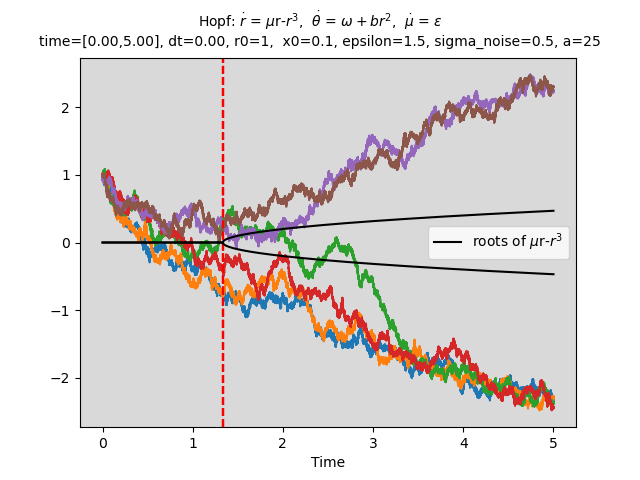

In [5]:
# Single run of run_bif_sim_and_plot

fig, axs = plt.subplots(1,1)
time = np.arange(0, 5, 0.00001)
r0 = 1
theta_0 = 0.1
mu_0 = -2
x0 = 0.1
b = 1
omega = 2
a = 25
epsilon = 1.5
sigma = 0.5

y0 = [r0, theta_0, mu_0]

ttl = r"Hopf: $\dot{r}$ = $\mu$r-$r^3$,  $\dot{\theta}$ = $\omega+br^2$,  $\dot{\mu}$ = $\epsilon$" + "\n" 

args = (epsilon, omega, b)

sims = []
for i in range(6):
    fig, axs, t_star, results, derivatives = run_bif_sim_and_plot(
        fig, axs, hh.hopf_model, time, r0, x0, epsilon, sigma_noise=sigma, a=a, ttl=ttl, model_args=args, y0=y0
    )

    rs, thetas, mus = results[:,0], results[:,1], results[:,2]
    slope,intercept,_,_,_ = linregress(time, mus)
    # mu=0=intercept+slope*t iff t=-intercept/slope
    t_star = -intercept/slope
    sims.append([t_star, results, derivatives])

plot_roots_of_hopf_radius(axs[0], results)
plt.show()

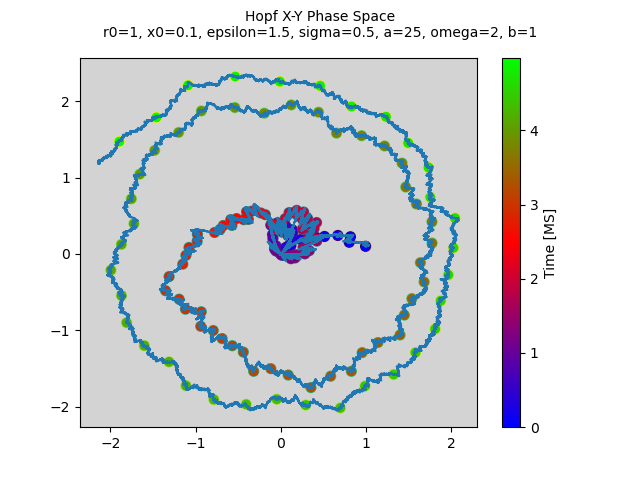

In [4]:
fig, ax = plt.subplots(1,1)
rs, thetas, mus = results[:,0], results[:,1], results[:,2]

x = rs*np.cos(thetas)
y = rs*np.sin(thetas)

ax.plot(x,y)

# scatter(t, datas[0][:, 2], c=t, cmap='brg')
step = 3000
ax.scatter(x[::step], y[::step], c=time[::step], s=50, label='start')

plt.colorbar(
    ax.scatter(x[::step], y[::step], c=time[::step], cmap='brg'), 
    ax=ax, label='Time [MS]'
)

ax.set_facecolor('lightgray')
ttl = f'Hopf X-Y Phase Space\nr0={r0}, x0={x0}, epsilon={epsilon}, sigma={sigma}, a={a}, omega={omega}, b={b}'
fig.suptitle(ttl, fontsize=10)

plt.show()